# Task 1

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import random

### Helper Functions

In [5]:
def scree_plot(n_comp):
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    scree_df = pd.DataFrame({'exp_var':pca.explained_variance_ratio_,
                 'PC':[i for i in range(1,n_comp+1)]})
    colors = [n_comp * ['blue'] + (20-n_comp) * ['red'] ]
    scree_df['colors'] = colors[0]
    sns.barplot(x='PC',y="exp_var", 
               data=scree_df, color="c");
    plt.tight_layout()
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Varaince')

def pcplot2d():
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = [('PC' + str(i)) for i in range(1,n_comp+1)])
    colors = []
    for i in labels:
        if i == 0:
            colors.append('neutral')
        else:
            colors.append('smile')
    pc_df['class'] =colors
    sns.lmplot( x="PC1", y="PC2",
      data=pc_df, 
      fit_reg=False, 
        hue='class', 
      legend=True,
      scatter_kws={"s": 80}) 
    
def pcplot3d():
    pca = PCA(n_components=3)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2','PC3'])

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=labels,depthshade=False)
    
def training_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_test_score']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_test_score']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Accuracy Score')
    # plt.title('Bayes Models: Number of Principal Components')
    plt.legend(loc=(.6,0.08))

def training_time_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_fit_time']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_fit_time']

    plt.figure(figsize=(6,4),dpi=100)
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Training Time')
    plt.legend()

def model_eval(model, X_test, y_test):
    ypred = model.predict(X_test)
    results = {'Accuracy' : [accuracy_score(y_test, ypred)],
               'F1': [f1_score(y_test, ypred)], 
               'Precision': [precision_score(y_test, ypred)],
                'Recall': [recall_score(y_test, ypred)], 
           'AUC': [roc_auc_score(y_test, ypred)]}
    results_df = pd.DataFrame(results)
    
    results_df = results_df.style.hide_index()
    return results_df

def confusion_matrix(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [6]:
#load data chunks and converts to numpy arrays
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    aug_neutral = np.load('data/aug_neutral.npy', allow_pickle=True)
    aug_smile = np.load('data/aug_smile.npy', allow_pickle=True)
    return raw_face, (raw_pose, raw_illum), (aug_neutral,aug_smile)

# creates face dataset and returns a tuple of 
def make_face_dataset(raw_face, augmented=False):
    neutral= raw_face[:,:,::3]
    smile = raw_face[:,:,1::3]
    variation = raw_face[:,:,2::3]
    
    if augmented == True:
        face_data = np.dstack((neutral, variation, smile))
        face_data = np.array(np.dsplit(face_data,face_data.shape[-1])).reshape((600,24,21))
        face_data = face_data/255
        face_data = face_data.reshape((600,24*21))
        face_labels = np.ravel(np.array([400 * [0] + 200 * [1]]))
        return face_data, face_labels
    else:
        face_data = np.dstack((neutral, smile))
        face_data = np.array(np.dsplit(face_data,face_data.shape[-1])).reshape((400,24,21))
        face_data = face_data/255
        face_data = face_data.reshape((400,24*21))
        face_labels = np.ravel(np.array([200 * [0] + 200 * [1]]))
        return face_data, face_labels

### load data and create dataset


In [7]:
#load data chunks
raw_face, raw_pose, aug_data = load_data_chunks()
#create face dataset
data, labels = make_face_dataset(raw_face, augmented=False)
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.15, random_state=42, shuffle='true', stratify=labels)
print(X_train.shape)
print(X_test.shape)

(340, 504)
(60, 504)


# Gaussian Bayes

In [8]:
#Bayes pipeline
scaler = StandardScaler()
pca = PCA()
gnb = GaussianNB()

pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('bayes', gnb)])
param_grid = {
    'pca__n_components': [i for i in range(1,40)]
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
bayes_search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
bayes_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % bayes_search.best_score_)
print(bayes_search.best_params_)
print(bayes_search.best_score_)

Best parameter (CV score=0.868):
{'pca__n_components': 16}
0.8676470588235293


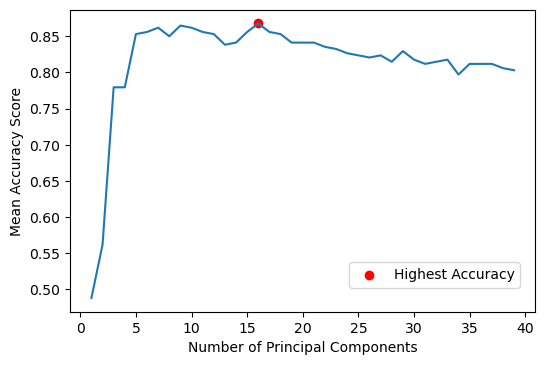

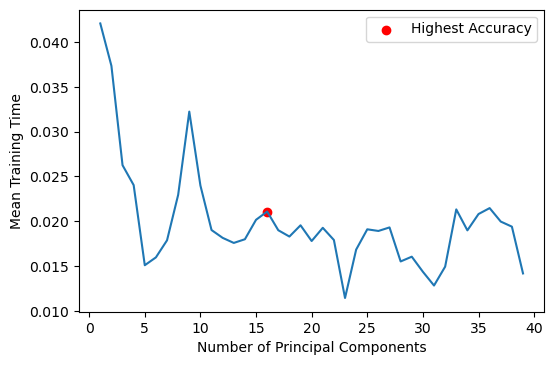

In [9]:
training_plot(bayes_search)
training_time_plot(bayes_search)

#### testing

In [186]:
model_eval(bayes_search, X_test, y_test)

Accuracy,F1,Precision,Recall,AUC
0.866667,0.862069,0.892857,0.833333,0.866667


# KNN

In [192]:
scaler = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('scaler', scaler),('pca', pca), ('knn', knn)])

param_grid = {
    'pca__n_components': [i for i in range(1,31)],
    'knn__n_neighbors' : [i for i in range(1,11)],  
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski','wminkowski','seuclidean','mahalanobis'],
    'knn__weights' : ['uniform','distance'],
    
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
knn_search = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
knn_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % knn_search.best_score_)
print(knn_search.best_params_)

Best parameter (CV score=0.916):
{'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'uniform', 'pca__n_components': 28}


#### testing

In [193]:
model_eval(knn_search, X_test, y_test)

Accuracy,F1,Precision,Recall,AUC
0.866667,0.851852,0.958333,0.766667,0.866667


# PCA Analysis

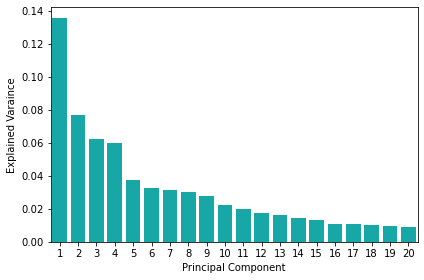

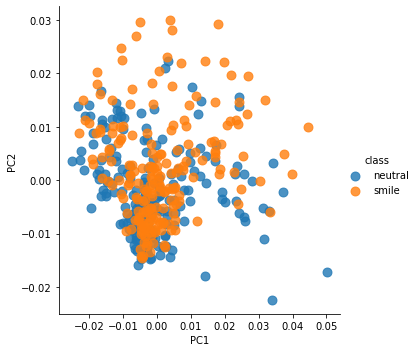

In [187]:
scree_plot(n_comp=16)
pcplot2d()